In [1]:
# Importing the libraries
import os
import re, string
import numpy as np
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

In [2]:
# Loading the training data
train_df = pd.read_csv("D:/Projects/toxic-comment-classification\data/raw-data/train.csv")
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [3]:
# Checking the total number of rows and column in our dataset
train_df.shape

(159571, 8)

In [50]:
# Loading the test data
test_data = pd.read_csv("D:/Projects/toxic-comment-classification\data/raw-data/test.csv")
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [49]:
# Loading the test labels
test_labels = pd.read_csv("D:/Projects/toxic-comment-classification/data/raw-data/test_labels.csv")
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [51]:
# Merging the two datasets above for complete test data
test_df = pd.merge(test_data, test_labels, on="id")
test_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [57]:
# Filtering out the samples having actual target labels
new_test_df = test_df[(test_df['toxic']!=-1) & (test_df['severe_toxic']!=-1) & (test_df['obscene']!=-1) & 
             (test_df['threat']!=-1) & (test_df['insult']!=-1) & (test_df['identity_hate']!=-1)]
new_test_df.reset_index(drop=True, inplace=True)
new_test_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
5,000663aff0fffc80,this other one from 1897,0,0,0,0,0,0
6,000689dd34e20979,== Reason for banning throwing == \n\n This ar...,0,0,0,0,0,0
7,000844b52dee5f3f,|blocked]] from editing Wikipedia. |,0,0,0,0,0,0
8,00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
9,000968ce11f5ee34,Please stop. If you continue to vandalize Wiki...,0,0,0,0,0,0


In [62]:
# Saving the new test dataset
new_test_df.to_csv("D:/Projects/toxic-comment-classification/data/raw-data/test_new.csv")

In [55]:
# Shape of new test data
new_test_df.shape

(63978, 8)

In [5]:
# Checking for missing values in train data
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [60]:
# Checking for missing values in test data
new_test_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

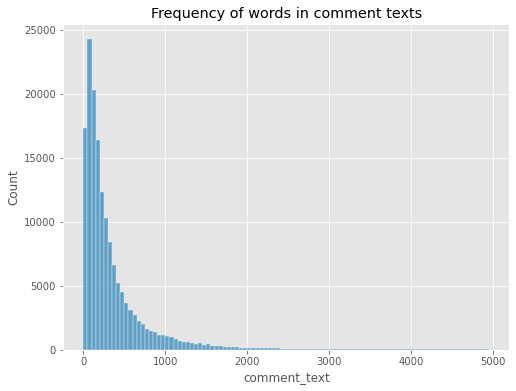

In [13]:
# Plotting the distribution of number of words in comments
count_words = train_df.comment_text.str.len()
plt.figure(figsize=(8,6))
sns.histplot(count_words, bins = np.arange(0, 5000, 50))
plt.title("Frequency of words in comment texts")
plt.show()

In [14]:
# Calculating the number of samples for each toxicity level class
target_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
total_samples = {}
for label in target_labels:
    total_samples[label] = train_df[train_df[label] == 1].shape[0]
total_samples

{'toxic': 15294,
 'severe_toxic': 1595,
 'obscene': 8449,
 'threat': 478,
 'insult': 7877,
 'identity_hate': 1405}

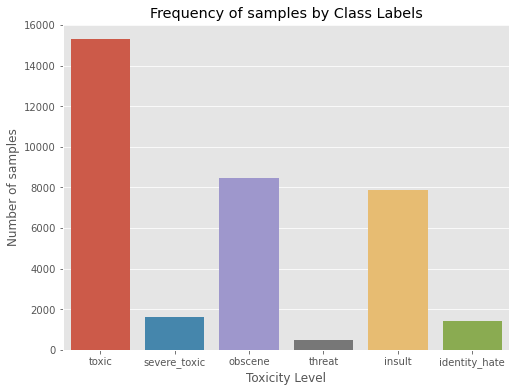

In [15]:
# Plotting a barplot to visualize the class samples frequency
plt.figure(figsize=(8, 6))
sns.barplot(x=list(total_samples.keys()), y=list(total_samples.values()))
plt.xlabel("Toxicity Level")
plt.ylabel("Number of samples")
plt.title("Frequency of samples by Class Labels")
plt.show()

In [16]:
# Percentage of Comments without any label category
print("Percentage of comments without any labels:")
print(len(train_df[(train_df['toxic']==0) & (train_df['severe_toxic']==0) & (train_df['obscene']==0) & 
             (train_df['threat']== 0) & (train_df['insult']==0) & (train_df['identity_hate']==0)]) / len(train_df))

Percentage of comments without any labels:
0.8983211235124177


In [9]:
# Let's check out some random examples of text for different toxicity levels

In [10]:
# Toxic level comments
print("Toxicity Level: toxic")
print(train_df[train_df["toxic"] == 1]["comment_text"].values[15])

Toxicity Level: toxic
"

SORRY PUCK BUT NO ONE EVER SAID DICK WAS NUMBER ONE!! But he is clearly listed as being ""second only to Batman"" and a ""master detective and martial artist"" and been trained in all the mentioned combat discplines. No need to mention in skills/abilities about the battles he's lost and won because thats not what an encylopia is supposed to do. 

Also, what your problem is your going by low end showings and not HIGH end showings where he's proven more than a match for a meta like Slade and pinned Shiva down in one of his earliest appearences.
 "


In [11]:
# Obscene level comments
print("Toxicity Level: obscene")
print(train_df[train_df["obscene"] == 1]["comment_text"].values[20])

Toxicity Level: obscene
Fuck you 

-User:The Bohemian Shinobis yeah, that's right, bitch! You are all pieces of shit!


In [12]:
# Severe toxic level comments
print("Toxicity Level: severe toxic")
print(train_df[train_df["severe_toxic"] == 1]["comment_text"].values[10])

Toxicity Level: severe toxic
Fuck you faggot, I don't care if i get blocked, as long as everyone knows you are a dumb cunt.


In [13]:
# insult level comments
print("Toxicity Level: insult")
print(train_df[train_df["insult"] == 1]["comment_text"].values[50])

Toxicity Level: insult
Why are you changing the SOMALI PEOPLE WIKI????????????????????/ 

SERIOUSLY????????? THAT PAGE IS BIASED TO ONE CLAN, I ADDED A MORE DIVERSE REPRESENTATION OF SOMALI PEOPLE!

YOU STUPID CRIMINAL.


In [17]:
# Creating a function to clean the training dataset
def clean_text(text):
    """This function will take text as input and return a cleaned text 
        by removing html char, punctuations, non-letters, newline and converting it 
        to lower case.

    Parameters
    ----------
    text : String
        Input raw text data string 

    Returns
    -------
    String
        Cleaned version of input text data
    """
    # Converting to lower case letters
    text = text.lower()
    # Removing the contraction of few words
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    # Replacing the HTMl characters with " "
    text = re.sub("<.*?>", " ", text)
    # Removing the punctuations
    text = text.translate(str.maketrans(" ", " ", string.punctuation))
    # Removing non-letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # Replacing newline with space
    text = re.sub("\n", " ", text)
    # Split on space and rejoin to remove extra spaces
    text = " ".join(text.split())
    
    return text

In [63]:
# Creating a function to remove english stopwords


def remove_stopwords(text):
    """This function will remove stopwords from a given text of data.

    Parameters
    ----------
    text : String
        Input raw text data string
    stop_words :  List
        List containing English stopwords

    Returns
    -------
    String
        Text without any stopwords
    """
    
    # Creating a list of english stopwords
    stop_words = set(stopwords.words("english"))
    # Tokenize the sentences to words
    text = word_tokenize(text)
    # Removing the stop words
    text = [word for word in text if not word in stop_words]
    # Joining the cleaned list
    text = " ".join(text)
    
    return text

In [19]:
# Applying the above functions on our train text data
train_df["comment_text"] = train_df["comment_text"].swifter.apply(clean_text)
train_df["comment_text"] = train_df["comment_text"].swifter.apply(remove_stopwords)
train_df.head()

Pandas Apply: 100%|██████████| 159571/159571 [03:24<00:00, 781.06it/s]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


In [64]:
# Applying the above functions on our test text data
new_test_df["comment_text"] = new_test_df["comment_text"].swifter.apply(clean_text)
new_test_df["comment_text"] = new_test_df["comment_text"].swifter.apply(remove_stopwords)
new_test_df.head()

Pandas Apply: 100%|██████████| 63978/63978 [01:19<00:00, 801.66it/s] 


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,thank understanding think highly would revert ...,0,0,0,0,0,0
1,000247e83dcc1211,dear god site horrible,0,0,0,0,0,0
2,0002f87b16116a7f,somebody invariably try add religion really me...,0,0,0,0,0,0
3,0003e1cccfd5a40a,says right type type institution needed case t...,0,0,0,0,0,0
4,00059ace3e3e9a53,adding new product list make sure relevant add...,0,0,0,0,0,0


In [65]:
# Saving the cleaned datasets as a csv file
train_df.to_csv("D:/Projects/toxic-comment-classification/data/cleaned-data/train-cleaned.csv")
new_test_df.to_csv("D:/Projects/toxic-comment-classification/data/cleaned-data/test-cleaned.csv")

In [21]:
# Importing the cleaned training dataset
# train_df = pd.read_csv("D:/Projects/toxic-comment-classification/data/cleaned-data/train-cleaned.csv")

(-0.5, 511.5, 511.5, -0.5)

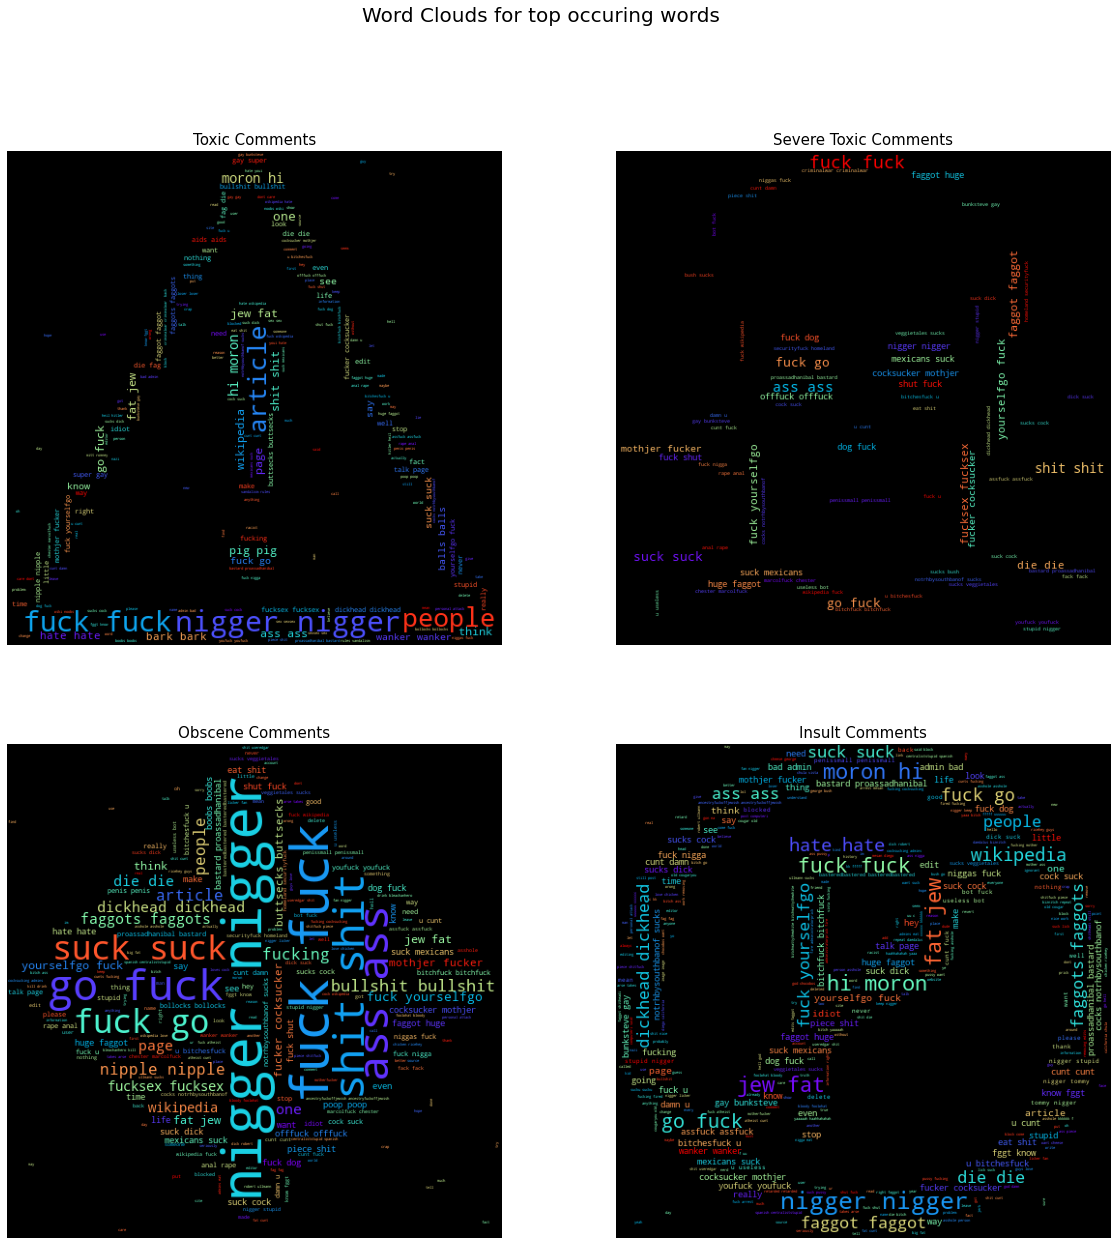

In [22]:
f, axarr = plt.subplots(2, 2, figsize=(20,20))
f.suptitle('Word Clouds for top occuring words', fontsize = 20)

toxic_mask = np.array(Image.open("D:/Projects/toxic-comment-classification/images/warning-symbol.png"))
wc = WordCloud(background_color="black", colormap="rainbow", max_words=4000, mask=toxic_mask)
wc.generate(" ".join(train_df[train_df["toxic"] == 1]["comment_text"].values))
axarr[0,0].set_title("Toxic Comments", fontsize=15)
axarr[0,0].imshow(wc)
axarr[0,0].axis('off')

severe_toxic_mask = np.array(Image.open("D:/Projects/toxic-comment-classification/images/skull.png"))
wc = WordCloud(background_color="black", colormap="rainbow", max_words=4000, mask=severe_toxic_mask)
wc.generate(" ".join(train_df[train_df["severe_toxic"] == 1]["comment_text"].values))
axarr[0,1].set_title("Severe Toxic Comments", fontsize=15)
axarr[0,1].imshow(wc)
axarr[0,1].axis('off')

obscene_mask = np.array(Image.open("D:/Projects/toxic-comment-classification/images/school-zone.png"))
wc = WordCloud(background_color="black", colormap="rainbow", max_words=4000, mask=obscene_mask)
wc.generate(" ".join(train_df[train_df["obscene"] == 1]["comment_text"].values))
axarr[1,0].set_title("Obscene Comments", fontsize=15)
axarr[1,0].imshow(wc)
axarr[1,0].axis('off')

insult_mask = np.array(Image.open("D:/Projects/toxic-comment-classification/images/no-parking.png"))
wc = WordCloud(background_color="black", colormap="rainbow", max_words=4000, mask=insult_mask)
wc.generate(" ".join(train_df[train_df["insult"] == 1]["comment_text"].values))
axarr[1,1].set_title("Insult Comments", fontsize=15)
axarr[1,1].imshow(wc)
axarr[1,1].axis('off')

In [23]:
def word_lemmatizer(text):
    """This function will help lemmatize words in a text.

    Parameters
    ----------
    text : String
        Input raw text data string

    Returns
    -------
    String
        Text after lemmatization
    """
    
    lemmatizer = WordNetLemmatizer()
    # Tokenize the sentences to words
    text = word_tokenize(text)
    # Removing the stop words
    text = [lemmatizer.lemmatize(word) for word in text]
    # Joining the cleaned list
    text = " ".join(text)
    
    return text

In [24]:
# Performing lemmatization on train data
train_df["comment_text"] = train_df["comment_text"].swifter.apply(word_lemmatizer)
train_df.head(10)

Pandas Apply: 100%|██████████| 159571/159571 [01:45<00:00, 1505.63it/s]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour seemingly stuck t...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0
5,00025465d4725e87,congratulation well use tool well talk,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0
7,00031b1e95af7921,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0


In [66]:
# Performing lemmatization on test data
new_test_df["comment_text"] = new_test_df["comment_text"].swifter.apply(word_lemmatizer)
new_test_df.head(10)

Pandas Apply: 100%|██████████| 63978/63978 [00:41<00:00, 1555.62it/s]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,thank understanding think highly would revert ...,0,0,0,0,0,0
1,000247e83dcc1211,dear god site horrible,0,0,0,0,0,0
2,0002f87b16116a7f,somebody invariably try add religion really me...,0,0,0,0,0,0
3,0003e1cccfd5a40a,say right type type institution needed case th...,0,0,0,0,0,0
4,00059ace3e3e9a53,adding new product list make sure relevant add...,0,0,0,0,0,0
5,000663aff0fffc80,one,0,0,0,0,0,0
6,000689dd34e20979,reason banning throwing article need section t...,0,0,0,0,0,0
7,000844b52dee5f3f,blocked editing wikipedia,0,0,0,0,0,0
8,00091c35fa9d0465,arab committing genocide iraq protest europe m...,1,0,0,0,0,0
9,000968ce11f5ee34,please stop continue vandalize wikipedia homos...,0,0,0,0,0,0


In [67]:
# Saving the lemmatized dataset as a csv file
train_df.to_csv("D:/Projects/toxic-comment-classification/data/cleaned-data/train-cleaned&lemmatized.csv")
new_test_df.to_csv("D:/Projects/toxic-comment-classification/data/cleaned-data/test-cleaned&lemmatized.csv")

In [39]:
# Creating a list of all the text comments from our cleaned dataset
corpus = list(train_df.comment_text.values)
print(len(corpus))

159571


In [40]:
# Calculating the TF-IDF values for our text data corpus
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 1), sublinear_tf=True, strip_accents="unicode", 
                             analyzer="word",token_pattern=r"\w{1,}")
X = vectorizer.fit_transform(corpus)
X.shape

(159571, 10000)

In [41]:
# Storing the target label columns in variable y
y_df = train_df.iloc[:,2:]
y = train_df.iloc[:,2:].values
y[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [42]:
# Creating a variable to store all the feature names selected by TF-IDf
features = vectorizer.get_feature_names()

In [43]:
# Creating a function to calculate top words based on tfidf in a sentence/row 
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# Since the output from tfidf-verctorizer is a huge sparse matrix, converting it to array before passing it as input
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [44]:
top_feats_in_doc(X, features=features, row_id = 6, top_n=5)

,feature,tfidf
0,cocksucker,0.665918
1,piss,0.574915
2,around,0.366166
3,work,0.303230
4,fastest,0.000000


In [45]:
# Creating a function to identify top words accross a corpus or multiple rows
def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
        
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [46]:
# Function to calcutate top feature based on target label
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = y_df.columns
    for label in labels:
        ids = y_df.index[y_df[label] == 1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [47]:
top_features_per_class = top_feats_by_class(X, features=features, top_n=10)

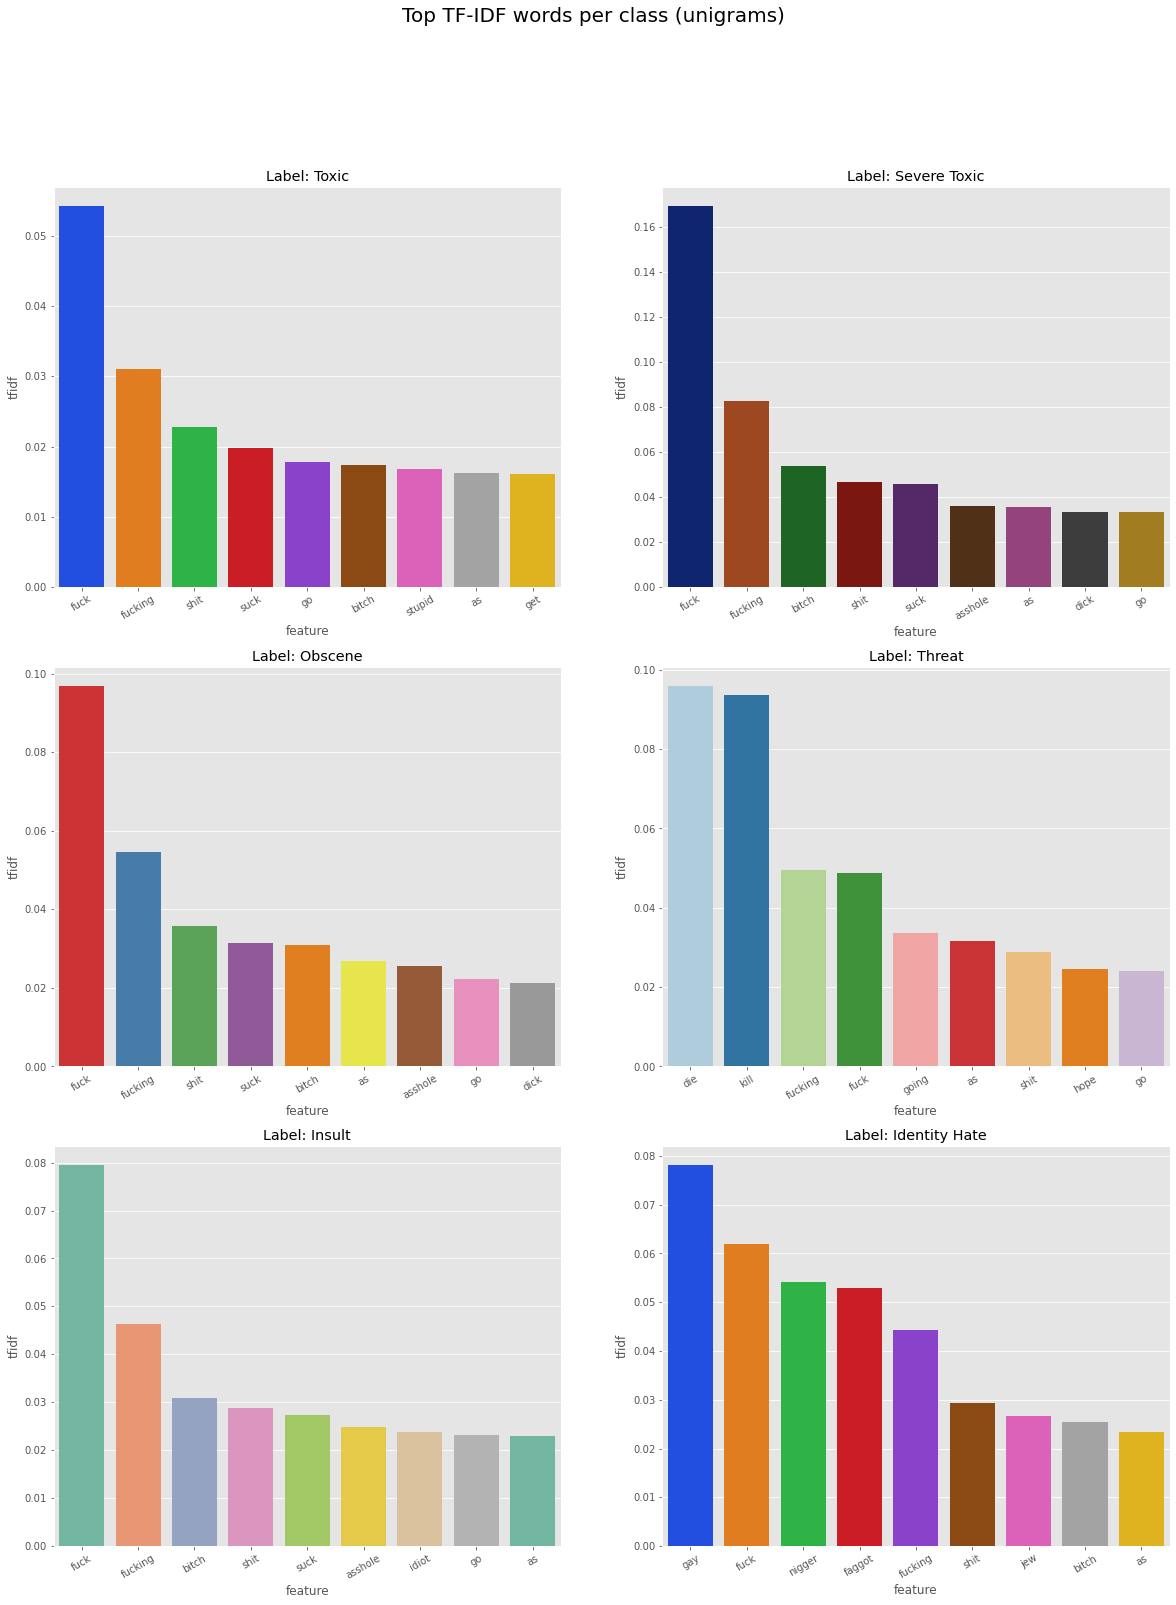

In [48]:
# Plotting the above results to get an overview
fig, axes = plt.subplots(3, 2, figsize = (20, 25), sharey= False)
fig.suptitle('Top TF-IDF words per class (unigrams)', fontsize = 20)

# Toxic
sns.barplot(ax=axes[0, 0], x=top_features_per_class[0].feature.iloc[0:9], y=top_features_per_class[0].tfidf.iloc[0:9], palette='bright')
axes[0, 0].set_title('Label: Toxic')
axes[0, 0].tick_params(axis = 'x', rotation=30, labelsize = 'medium')

# Severe Toxic
sns.barplot(ax=axes[0, 1], x=top_features_per_class[1].feature.iloc[0:9], y=top_features_per_class[1].tfidf.iloc[0:9], palette='dark')
axes[0, 1].set_title('Label: Severe Toxic')
axes[0, 1].tick_params(axis = 'x', rotation=30, labelsize = 'medium')

# Obscene
sns.barplot(ax=axes[1, 0], x=top_features_per_class[2].feature.iloc[0:9], y=top_features_per_class[2].tfidf.iloc[0:9], palette='Set1')
axes[1, 0].set_title('Label: Obscene')
axes[1, 0].tick_params(axis = 'x', rotation=30, labelsize = 'medium')

# Threat
sns.barplot(ax=axes[1, 1], x=top_features_per_class[3].feature.iloc[0:9], y=top_features_per_class[3].tfidf.iloc[0:9], palette='Paired')
axes[1, 1].set_title('Label: Threat')
axes[1, 1].tick_params(axis = 'x', rotation=30, labelsize = 'medium')

# Insult
sns.barplot(ax=axes[2, 0], x=top_features_per_class[4].feature.iloc[0:9], y=top_features_per_class[4].tfidf.iloc[0:9], palette='Set2')
axes[2, 0].set_title('Label: Insult')
axes[2, 0].tick_params(axis = 'x', rotation=30, labelsize = 'medium')


# Identity hate
sns.barplot(ax=axes[2, 1], x=top_features_per_class[5].feature.iloc[0:9], y=top_features_per_class[5].tfidf.iloc[0:9], palette='bright')
axes[2, 1].set_title('Label: Identity Hate')
axes[2, 1].tick_params(axis = 'x', rotation=30, labelsize = 'medium')

### Now, let's move to the model building part!